/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_81979/822777291.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed

Coefficient: -0.000111394588149938
Intercept: 0.0073992291018776185
R^2: 0.028578268732827983


Price,Close,High,Low,Open,Volume,shift(1),Target,RSI,Predictions
8174,627.121338,627.988928,624.458737,627.360665,60046300,632.456604,0.008508,64.465096,0.000218
8175,632.456604,632.456604,627.988949,629.803924,70511000,632.665955,0.000331,69.988460,-0.000397
8176,632.665955,634.391213,632.237151,632.845450,71307100,635.338562,0.004224,65.265656,0.000129
8177,635.338562,635.817276,633.084861,633.334170,56865400,635.179016,-0.000251,79.574963,-0.001465
8178,635.179016,636.275951,633.782862,635.717501,54917100,633.503662,-0.002638,80.094315,-0.001523
...,...,...,...,...,...,...,...,...,...
8255,672.039978,680.859985,670.520020,680.500000,103457800,671.929993,-0.000164,45.886617,0.002288
8256,671.929993,675.659973,663.270020,665.380005,96846700,665.669983,-0.009316,37.998228,0.003166
8257,665.669983,673.710022,662.169983,669.700012,90456100,660.080017,-0.008398,32.142289,0.003819
8258,660.080017,665.119995,655.859985,662.099976,114467500,662.630005,0.003863,29.040705,0.004164


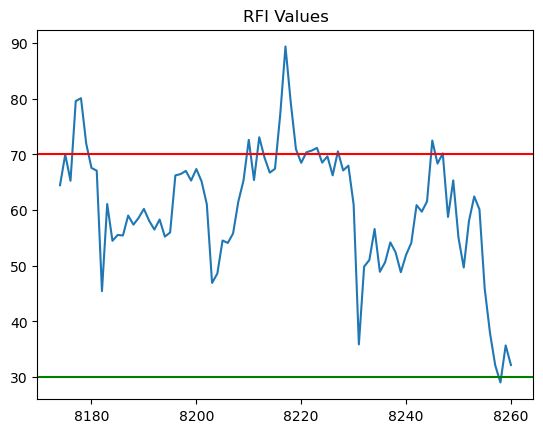

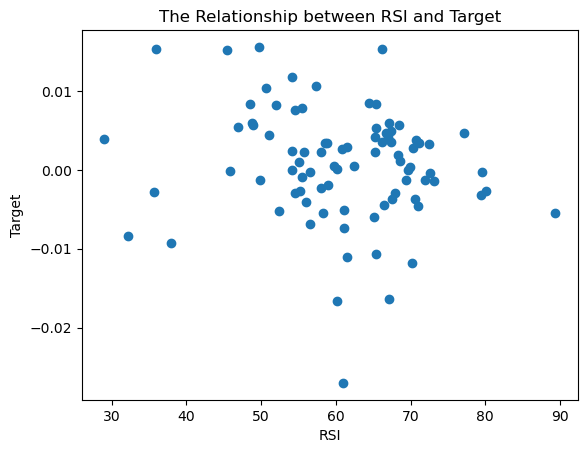

In [ ]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn as sk

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

# Step 3: Price difference
SHIFT = 1
    # Tomorrow's Close Price in the same Row as today

STRATEGY = "RSI"

# Step 5: Data Subsection
LOOKBACK = 100

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    return df.iloc[-lookback:, :]
        # -lookback: all loockback rows
        # : all columns 

# Defining y/Dependent/Target Variable
# --> We can create a strategy, that could forecast a positively/negatively correlation 
# with our Close Price changes 

def add_target(df, shift = SHIFT):

    # Step 1: How does the price change one day from now
    df[f"shift({shift})"] = df["Close"].shift(-shift)
        # shift(-1): shift backwards in time. It takes the diff value from tomorrow into the row for today
        # We are trying to find a correlation with the price of tomorrow

    # Step 2: Finding Momentum. What is the difference between Close Price today and five days from now?
    # Abolute Price Changes: 
    # df["Target"] = df[f"diff().shift({shift})"] - df["Close"]
    # Relarive Price Changes:
    df["Target"] = (df[f"shift({shift})"] - df["Close"])/df["Close"]
        # Percentage Changes are very small 

    return df

# Adding the Features/Independent Var: we want to create a Corelation between the Target and RSI 

# Lets inspect how a tech Indicator is related to how a price changes tomorrow
# For eg. RSI - you want to see a negative correlation between value of the RSI
# and Close Price Change the following day. Because the higher the value of RSI, 
# the more overbought the asset, the lower the Closing Price 

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    
    # Step 1: Define Delta (Price changes between the Rows)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Negative Returns
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # Step 3: Calculate the Rolling Average for Length Days
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    # Step 4: Calculate the Relative Strength
    rs = avg_gain / avg_loss
        # In percentage Terms: how much stronger have the Up Days been compared to the Down Days
        # rs = 3: avg_gain was 3x larger than the average loss --> Strong Upward Momentum
        # rs = 0.5: avg_gain was half the size of the average loss --> Strong Downward Momentum

    # Step 5: Calculate the RSI w/ Standardization (Values between 0-100)
    df["RSI"] = 100 - (100/(1+rs))

    # Step 6: Plot the RSI
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Step 7: Plot horizontal lines for Overbrought/Oversold
    plt.axhline(overbrought, color="red") # Crossing Overbrought Line: triggers Short Signal
    plt.axhline(oversold, color="green") # Crossing Oversold Line: triggers Long Signal
    
    return df.dropna()

# Using our Scikit Library, to understand how our RSI is related to future price movements
# --> Looking for high R^2 Values

def generate_regression_output(df, features="RSI", target="Target"):

    # Step 1: Subset Data
    subset = df[[features,target]].dropna()
        # df[[x, y]]: Selects only the columns RSI and Target from df

    # Step 2: Convert df (Pandas) into NumPy array format (Reshape for Sklearn)
    X = subset[[features]].values # 2d
        # Converts the feature column (x, e.g., 'RSI') into a NumPy array
        # [[x]]: selects the data as a DataFrame (even if it's just one column)
        # .values: extracts the data as a 2D NumPy array (e.g., [[80], [75], [70]]) - standard shape for features by sklearn
    y = subset[target].values #1d
        # [y]: selects the data as a Series
        # .values: extracts the data as a 1D NumPy array (e.g., [0.02, -0.01, 0.03]) - standard shape for the target by sklearn

    # Step 3: Model
    model = sk.linear_model.LinearRegression()
        # Creates a blank LR model object - to find the best straight line to describe the relationship between X and Y
    model.fit(X,y)
        # It feeds the model with X and Y, which adjusts the slope and y-intercept of the line, to minimizes the distance between its prediction and the true answer

    # Step 4: Use the Regression Model to predict the target variable 
    y_pred = model.predict(X)
        # It takes the trained model (the best-fit line) and feeds it your features
        # y_pred: generated array, contains the model's prediction for the target 

    # Step 5: what is the relationship between Features and Target
    r2 = sk.metrics.r2_score(y, y_pred)
        # r2: how much of the dependent variable (actual price change, y) is predictable from the features (RSI, x)
        # 1.0 (100%)Perfect Fit: Your RSI perfectly predicts the future price change. (Unlikely in trading).$
        # 0.2 (20%)Weak Fit: Your model explains 20% of the movement, and 80% is still unexplained noise.
        # 0.0 (0%)No Predictive Power: Your model is no better at predicting the outcome than simply using the historical average
        # Negative: Worse than Useless. Your model is making predictions that are actively worse than just guessing the mean.
        # In statistics, the mean (average) is the simplest possible forecast that minimizes the sum of squared errors for any dataset.

    # Step: Make Coefficient & Intercept Variable 
    coefficient = model.coef_[0]
    intercept = model.intercept_
    
    # Step 6: coef, Intercept, r2...mse later on
    print(f"Coefficient: {coefficient}")
    print(f"Intercept: {intercept}")
    print(f"R^2: {r2}")
        # Printing the Formula: Y_predi = Intercept + (Coefficient * X)
        # Coefficient: slope of the line (strength and direction of the relationship) 
        # Intercept: It's the predicted target (y) if your feature (x) were equal to zero.

    # IMPORTANT NOTE (we will do later on):
        # Verify for Homoskedasticity, before runnin a Regression Analysis
        # We assumed that, in this case, but we will prove it by using percentage change later on

    # Step 7: To better understand it, lets build a Scatter Plot
    plt.figure()
    plt.title(f"The Relationship between {features} and {target}")
    plt.scatter(X, y)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
        # As we can see the results look flat and random, and we cant identify any direction 

    return coefficient, intercept


def test_linearity(df, coef, intercept):

    # Ypred = a + bx
    df["Predictions"] = intercept + coef * df[f"{STRATEGY}"] 

    return df


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    fit_coef, fit_intercept = generate_regression_output(df)
    df = test_linearity(df, coef=fit_coef, intercept=fit_intercept)

    return df

df = main()
df